## E-commerce Customer Segmentation System

### This is an unsupervised machine learning model to group customers into meaningful clusters. 

## Problem Statement

SmartCart uses *generic marketing* and *engagement strategies* for *all customers*, without clear understanding of different customer behavior patterns.

### Challenges Faced 

1. *Inefficient marketing* ,
2. *Missed opportunities* to retain *high-value customers* ,
3. *Delayed identification* of *churn-prone users* .

## Tech Stack & Tools

* Programming Language : Python
* Libraries : NumPy,Pandas,Matplotlib,Seaborn,Scikit-learn,Kneed
* Environment : Jupyter Notebook

### Importing basic Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

## Initial data inspection

In [2]:
df = pd.read_csv("smartcart_customers.csv")
df
df.head()
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [3]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Complain                0
Response                0
dtype: int64

## Data preprocessing

### 1. Handle missing values

In [4]:
df["Income"] = df["Income"].fillna(df["Income"].median())

In [5]:
df.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Complain               0
Response               0
dtype: int64

## 2. Feature Engineering 

In [6]:
# a. Year_Birth -> Age 
df["Age"] = 2026-df["Year_Birth"]

In [7]:
# b. Customer joining date -> Customer Tenure Days
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"],dayfirst = True)
reference_dt = (df["Dt_Customer"]).max()
df["CustomerTenureDays"] = (reference_dt - df["Dt_Customer"]).dt.days

In [8]:
# c.Customer spending
df.columns
df["TotalSpending"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

In [9]:
# d.Total children = kids + teenagers
df["TotalChildren"] = df["Kidhome"] + df["Teenhome"]

In [10]:
# e. Education 
df["Education"].value_counts()

# 3 main categories = Undergraduate,Graduate,Postgraduate
df["Education"] = df["Education"].replace(
    {
        "Basic":"Undergraduate",
        "2n Cycle":"Undergraduate",
        "Graduation":"Graduate",
        "PhD":"Postgraduate",
        "Master":"Postgraduate"
    }
)

In [11]:
df["Education"].value_counts()

Education
Graduate         1127
Postgraduate      856
Undergraduate     257
Name: count, dtype: int64

In [12]:
# marital status 
df["Marital_Status"].value_counts()
df["LivingWith"]=df["Marital_Status"].replace(
    {
        "Married":"Partner",
        "Together":"Partner",
        "Single":"Alone",
        "Divorced":"Alone",
        "Widow":"Alone",
        "Alone":"Alone",
        "Absurd":"Alone",
        "YOLO":"Alone",
    }
)

In [13]:
df["LivingWith"].value_counts()

LivingWith
Partner    1444
Alone       796
Name: count, dtype: int64

## Drop unnecessary columns 

In [14]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,CustomerTenureDays,TotalSpending,TotalChildren,LivingWith
0,5524,1957,Graduate,Single,58138.0,0,0,2012-09-04,58,635,...,10,4,7,0,1,69,663,1617,0,Alone
1,2174,1954,Graduate,Single,46344.0,1,1,2014-03-08,38,11,...,1,2,5,0,0,72,113,27,2,Alone
2,4141,1965,Graduate,Together,71613.0,0,0,2013-08-21,26,426,...,2,10,4,0,0,61,312,776,0,Partner
3,6182,1984,Graduate,Together,26646.0,1,0,2014-02-10,26,11,...,0,4,6,0,0,42,139,53,1,Partner
4,5324,1981,Postgraduate,Married,58293.0,1,0,2014-01-19,94,173,...,3,6,5,0,0,45,161,422,1,Partner


In [15]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Complain', 'Response', 'Age', 'CustomerTenureDays', 'TotalSpending',
       'TotalChildren', 'LivingWith'],
      dtype='object')

In [16]:
# droping unnecessary columns
cols=["ID","Year_Birth","Marital_Status","Kidhome","Teenhome","Dt_Customer"]
spending_cols=["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"]
cols_to_drop = cols + spending_cols
df_cleaned = df.drop(columns = cols_to_drop)

In [17]:
df_cleaned.shape

(2240, 15)

In [18]:
df.shape

(2240, 27)

In [19]:
df_cleaned.head()

,Education,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,CustomerTenureDays,TotalSpending,TotalChildren,LivingWith
0,Graduate,58138.0,58,3,8,10,4,7,0,1,69,663,1617,0,Alone
1,Graduate,46344.0,38,2,1,1,2,5,0,0,72,113,27,2,Alone
2,Graduate,71613.0,26,1,8,2,10,4,0,0,61,312,776,0,Partner
3,Graduate,26646.0,26,2,2,0,4,6,0,0,42,139,53,1,Partner
4,Postgraduate,58293.0,94,5,5,3,6,5,0,0,45,161,422,1,Partner


## Outlier detection and removal

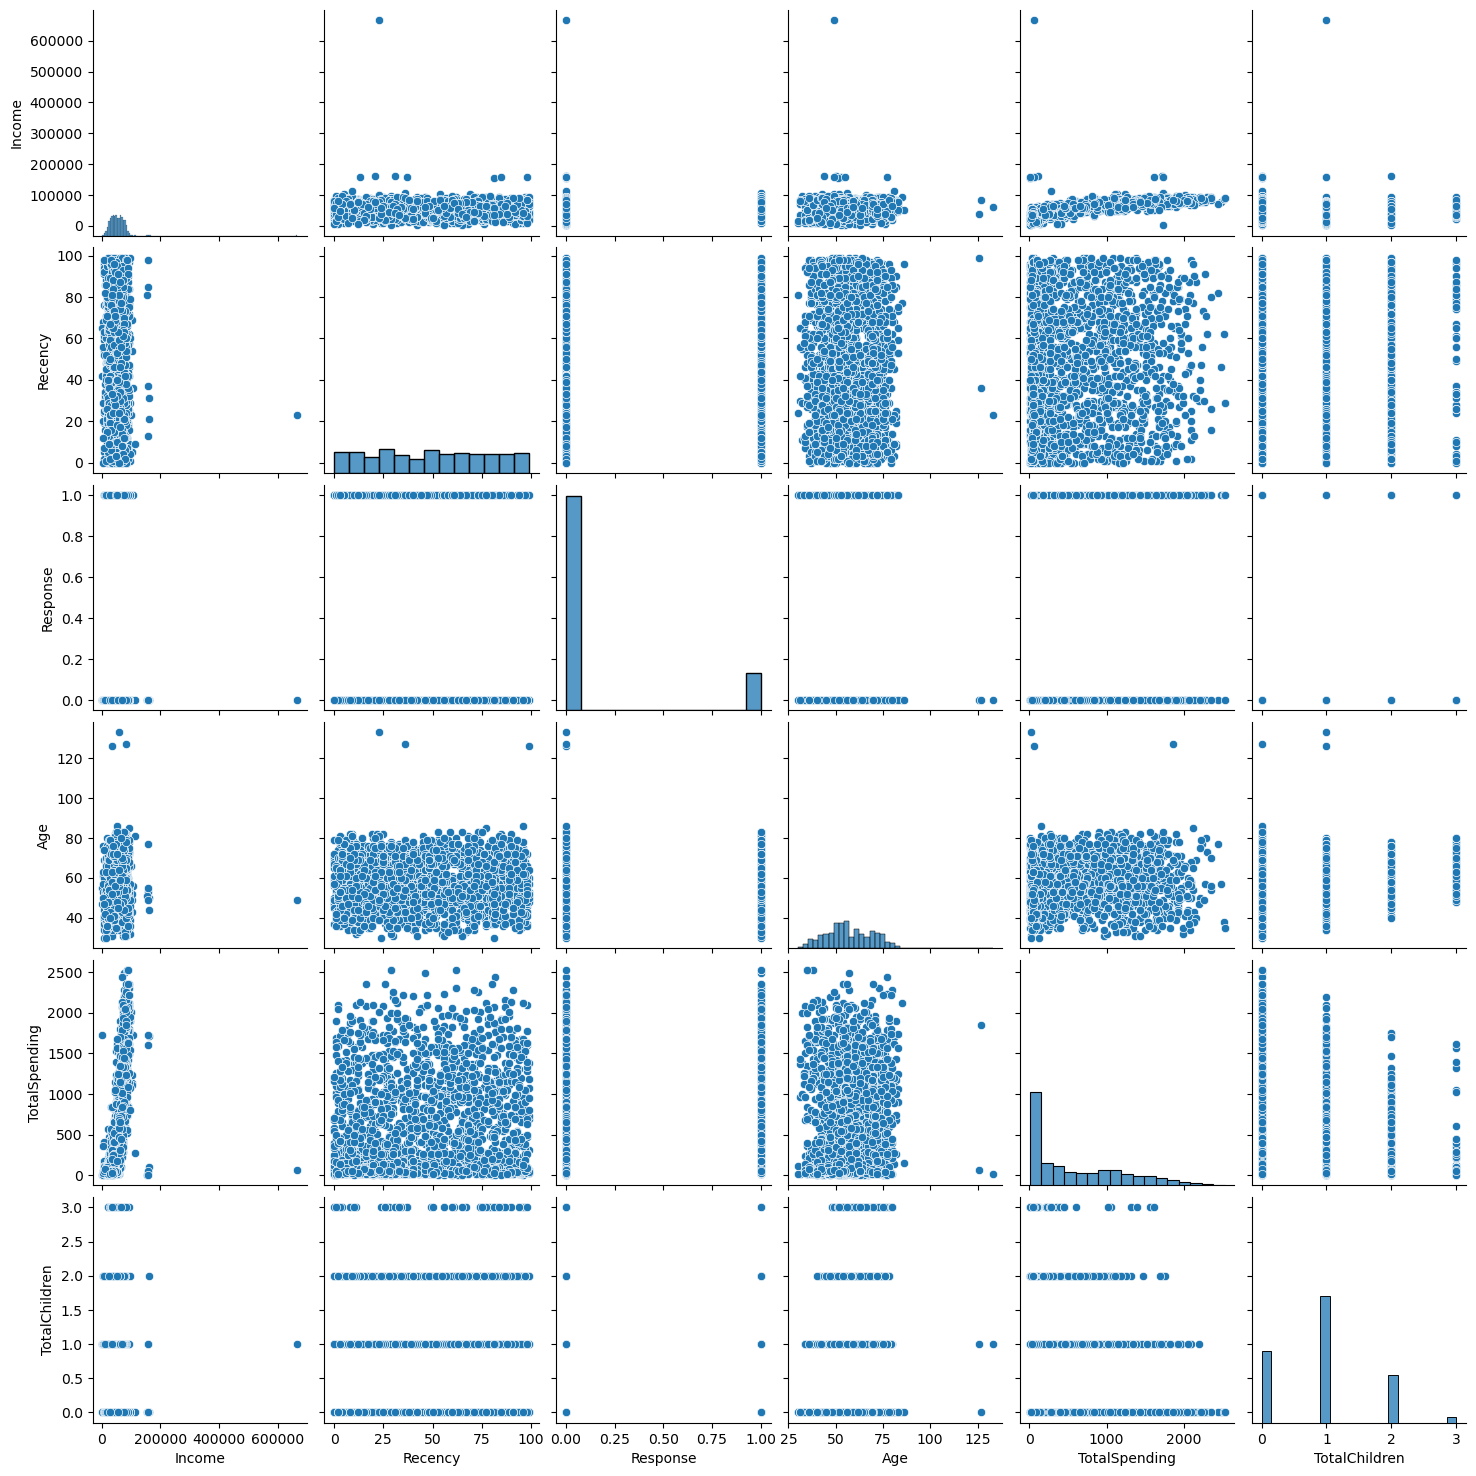

In [20]:
cols = ["Income","Recency","Response","Age","TotalSpending","TotalChildren"]
# relative plots of some features 
sns.pairplot(
    df_cleaned[cols]
)

In [21]:
# remove the outliers 
print("data size with outlier :",len(df_cleaned))

df_cleaned = df_cleaned[ (df_cleaned["Age"]<90) ]
df_cleaned = df_cleaned[ (df_cleaned["Income"]<600000) ]

print("data size without outliers :",len(df_cleaned))

data size with outlier : 2240
data size without outliers : 2236


## Correlation between different features

In [22]:
corr_matrix = df_cleaned.corr(numeric_only=True)
corr_matrix

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,CustomerTenureDays,TotalSpending,TotalChildren
Income,1.000000,0.007829,-0.107169,0.450584,0.693781,0.628075,-0.646382,-0.027871,0.161121,0.198835,-0.023677,0.789375,-0.340550
Recency,0.007829,1.000000,-0.000638,-0.010776,0.025226,0.000771,-0.021850,0.005361,-0.198781,0.019396,0.024238,0.020842,0.017826
NumDealsPurchases,-0.107169,-0.000638,1.000000,0.233971,-0.008510,0.068418,0.347216,0.003636,0.002017,0.068286,0.218009,-0.064831,0.439682
NumWebPurchases,0.450584,-0.010776,0.233971,1.000000,0.378049,0.502227,-0.056204,-0.013250,0.148390,0.153873,0.191211,0.519948,-0.146429
NumCatalogPurchases,0.693781,0.025226,-0.008510,0.378049,1.000000,0.518788,-0.520376,-0.018304,0.220813,0.125285,0.095836,0.778343,-0.439631
NumStorePurchases,0.628075,0.000771,0.068418,0.502227,0.518788,1.000000,-0.429857,-0.011563,0.038702,0.139237,0.109727,0.675460,-0.321729
NumWebVisitsMonth,-0.646382,-0.021850,0.347216,-0.056204,-0.520376,-0.429857,1.000000,0.020796,-0.004397,-0.117498,0.272105,-0.499909,0.417908
Complain,-0.027871,0.005361,0.003636,-0.013250,-0.018304,-0.011563,0.020796,1.000000,0.000167,0.004450,0.035685,-0.033784,0.031480
Response,0.161121,-0.198781,0.002017,0.148390,0.220813,0.038702,-0.004397,0.000167,1.000000,-0.018557,0.194232,0.265615,-0.169451
Age,0.198835,0.019396,0.068286,0.153873,0.125285,0.139237,-0.117498,0.004450,-0.018557,1.000000,-0.016451,0.113618,0.095512


<Axes: >

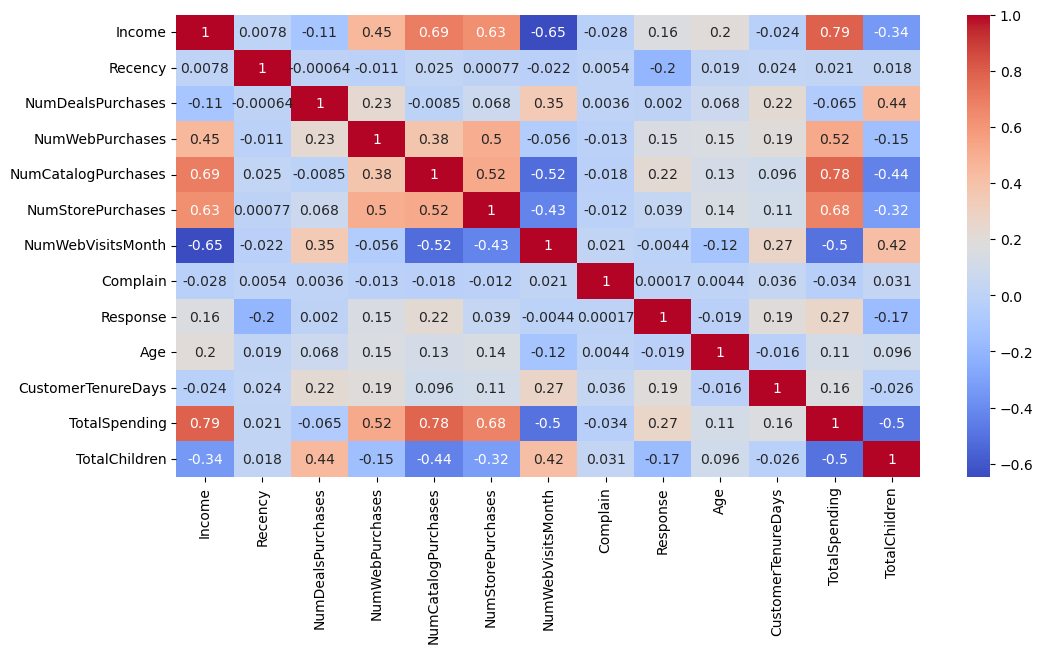

In [23]:
# correlation matrix into heatmap
plt.figure(figsize=(12,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    #annot_kws={"size":6},
    cmap="coolwarm"
)


## Insights

1. Income and TotalSpending have a strong positive correlation.(0.79)
2. Income and NumCatalogPurchases have a strong positive correlation.(0.69)
3. Income and NumStorePurchases have a strong positive correlation.(0.63)
4. Income and NumWebVisitsMonth have a strong negative correlation.(-0.65)
5. TotlaSpending and NumCatalogPurchases have a strong positive correlation.(0.78)
6. TotlaSpending and NumStorePurchases have a strong positive correlation.(0.68)

In [24]:
df_cleaned.shape

(2236, 15)

In [25]:
df_cleaned.head()

,Education,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,CustomerTenureDays,TotalSpending,TotalChildren,LivingWith
0,Graduate,58138.0,58,3,8,10,4,7,0,1,69,663,1617,0,Alone
1,Graduate,46344.0,38,2,1,1,2,5,0,0,72,113,27,2,Alone
2,Graduate,71613.0,26,1,8,2,10,4,0,0,61,312,776,0,Partner
3,Graduate,26646.0,26,2,2,0,4,6,0,0,42,139,53,1,Partner
4,Postgraduate,58293.0,94,5,5,3,6,5,0,0,45,161,422,1,Partner


## Encoding of categorical features

In [26]:
# Education and LivingWith
ohe = OneHotEncoder()
cat_cols = ["Education","LivingWith"]
encoded_cols = ohe.fit_transform(df_cleaned[cat_cols])

In [27]:
encoded_df = pd.DataFrame(encoded_cols.toarray(),columns=ohe.get_feature_names_out(cat_cols),index=df_cleaned.index)

In [28]:
encoded_df.head()

,Education_Graduate,Education_Postgraduate,Education_Undergraduate,LivingWith_Alone,LivingWith_Partner
0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0


In [29]:
df_encoded = pd.concat([df_cleaned.drop(columns=cat_cols),encoded_df],axis=1)

In [30]:
df_encoded.shape

(2236, 18)

In [31]:
df_encoded.head()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,CustomerTenureDays,TotalSpending,TotalChildren,Education_Graduate,Education_Postgraduate,Education_Undergraduate,LivingWith_Alone,LivingWith_Partner
0,58138.0,58,3,8,10,4,7,0,1,69,663,1617,0,1.0,0.0,0.0,1.0,0.0
1,46344.0,38,2,1,1,2,5,0,0,72,113,27,2,1.0,0.0,0.0,1.0,0.0
2,71613.0,26,1,8,2,10,4,0,0,61,312,776,0,1.0,0.0,0.0,0.0,1.0
3,26646.0,26,2,2,0,4,6,0,0,42,139,53,1,1.0,0.0,0.0,0.0,1.0
4,58293.0,94,5,5,3,6,5,0,0,45,161,422,1,0.0,1.0,0.0,0.0,1.0


In [32]:
X = df_encoded

## Scaling

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

In [34]:
X_scaled

array([[ 0.28894655,  0.30685572,  0.34873831, ..., -0.35877969,
         1.3476353 , -1.3476353 ],
       [-0.262003  , -0.38397129, -0.16869955, ..., -0.35877969,
         1.3476353 , -1.3476353 ],
       [ 0.91842301, -0.7984675 , -0.68613742, ..., -0.35877969,
        -0.74204052,  0.74204052],
       ...,
       [ 0.234898  ,  1.44672029, -0.68613742, ..., -0.35877969,
         1.3476353 , -1.3476353 ],
       [ 0.80780332, -1.42021181, -0.16869955, ..., -0.35877969,
        -0.74204052,  0.74204052],
       [ 0.04280841, -0.31488859,  0.34873831, ..., -0.35877969,
        -0.74204052,  0.74204052]])

## Visualize

In [35]:
X_scaled.shape # it is difficult for human eyes to visualize 18 dimensions so we have to use PCA technique

(2236, 18)

## 3D - PCA

In [36]:
pca = PCA(
    n_components = 3,
    random_state = 42
)
X_pca = pca.fit_transform(X_scaled)

In [37]:
pca.explained_variance_ratio_ # we will be able to capture 44% variance with the help of 2D data

array([0.23163158, 0.11385454, 0.10405815])

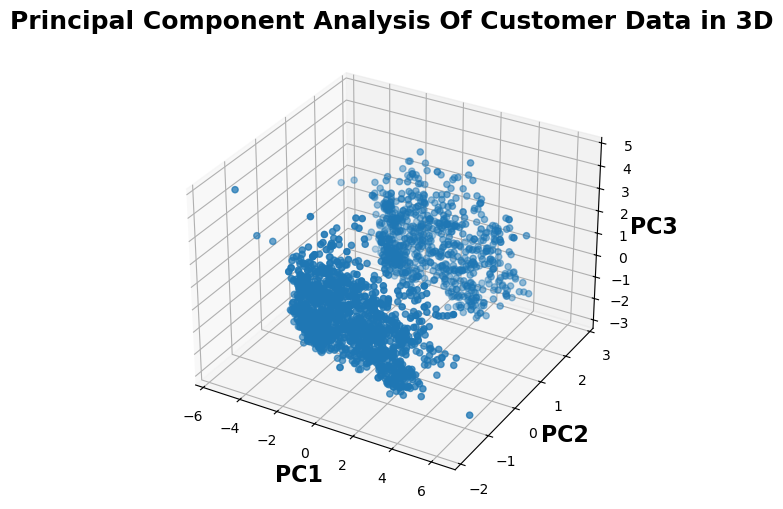

In [38]:
# 3D Plot
fig = plt.figure(
    figsize=(8,6)
)

ax = fig.add_subplot(111,projection="3d")
ax.scatter(
    X_pca[:,0],
    X_pca[:,1],
    X_pca[:,2],
)
ax.set_xlabel("PC1",fontsize=16,fontweight="bold")
ax.set_ylabel("PC2",fontsize=16,fontweight="bold")
ax.set_zlabel("PC3",fontsize=16,fontweight="bold")
ax.set_title("Principal Component Analysis Of Customer Data in 3D",fontsize=18,fontweight="bold")
plt.show()

## Analyze the K value

## 1. Elbow Method

In [39]:
# elbow method 
wcss = []
for k in range(1,11):
    kmeans = KMeans(
        n_clusters = k,
        random_state = 42,
    )
    labels = kmeans.fit_predict(X_pca)
    wcss.append(kmeans.inertia_)
    


C:\Users\HOME\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\HOME\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\HOME\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HOME\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^

In [40]:
kneedle=KneeLocator(
    x= range(1,11),
    y= wcss,
    curve="convex",
    direction="decreasing"
)
optimal_k = kneedle.elbow

In [41]:
print("Optimal K value is: ",optimal_k)

Optimal K value is:  4


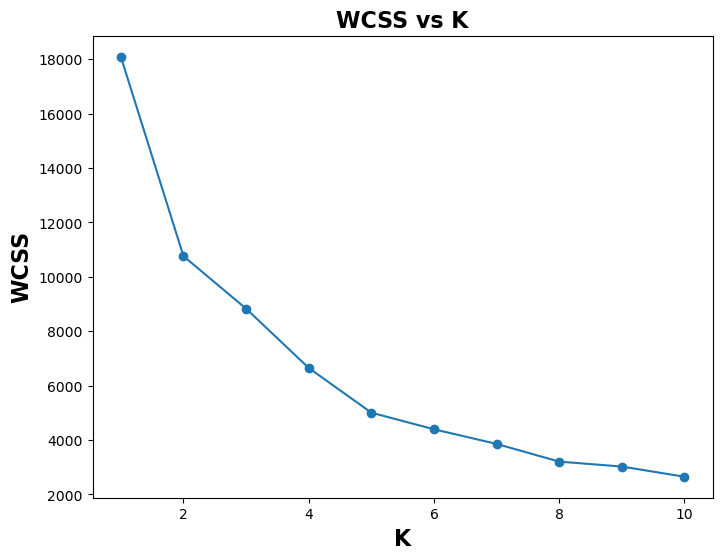

In [42]:
# plot for elbow method for finding the best k value 
plt.figure(figsize=(8,6))
plt.plot(
    range(1,11),
    wcss,
    marker = "o"
)
plt.xlabel("K",fontsize=16,fontweight="bold")
plt.ylabel("WCSS",fontsize=16,fontweight="bold")
plt.title("WCSS vs K",fontsize=16,fontweight="bold")
plt.show()

## Silhouette Score 

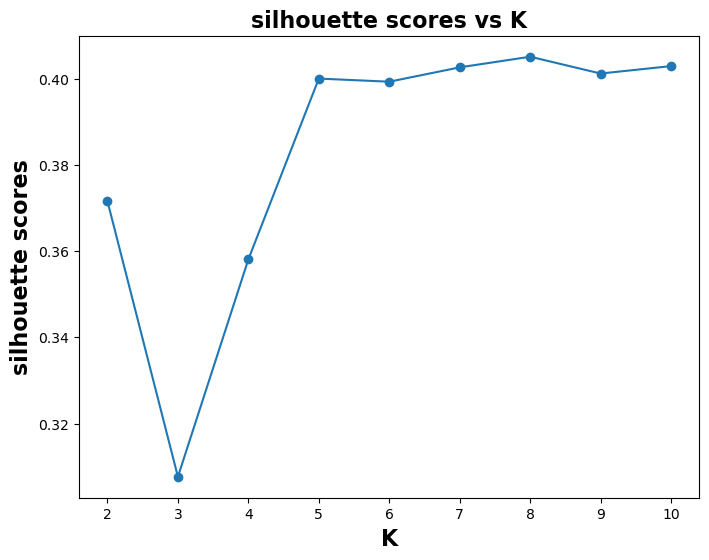

In [43]:
scores = []
for k in range (2,11):
    kmeans = KMeans(
        n_clusters = k,
        random_state = 42
    )
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca,labels)
    scores.append(score)

# plot for silhouette score
plt.figure(figsize=(8,6))
plt.plot(
    range(2,11),
    scores,
    marker = "o"
)
plt.xlabel("K",fontsize=16,fontweight="bold")
plt.ylabel("silhouette scores",fontsize=16,fontweight="bold")
plt.title("silhouette scores vs K",fontsize=16,fontweight="bold")
plt.show()
    

Text(0, 0.5, 'silhouette score')

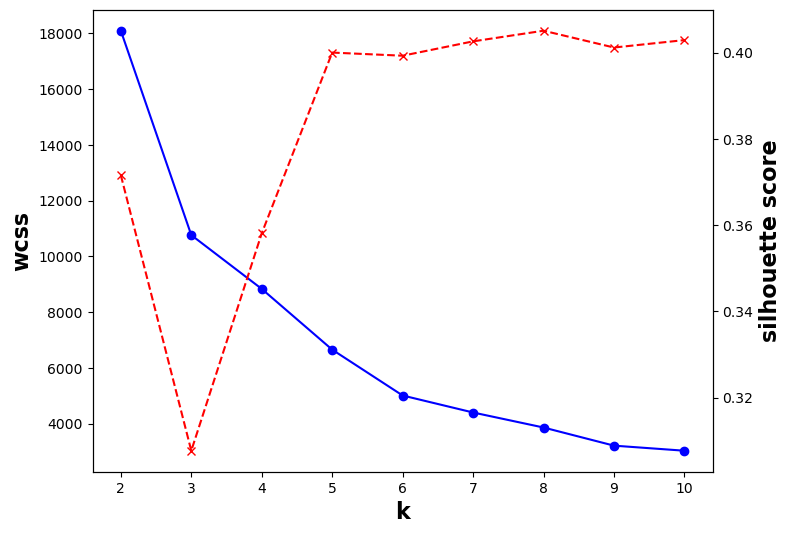

In [44]:
# combined plot for both wcss and silhouette score
k_range = range(2,11)
fig,ax1= plt.subplots(figsize=(8,6))
ax1.plot(
    k_range,
    wcss[:len(k_range)],
    marker="o",
    color="blue"
)
ax1.set_xlabel("k",fontsize=16,fontweight="bold")
ax1.set_ylabel("wcss",fontsize=16,fontweight="bold")


# axes 2
ax2 = ax1.twinx()
ax2.plot(
    k_range,
    scores[:len(k_range)],
    marker = "x",
    color = "red",
    linestyle="--"
)

ax2.set_ylabel("silhouette score",fontsize=16,fontweight="bold")




## Clustering Model 

## 1. KMeans

In [45]:
kmeans = KMeans(
    n_clusters = 4,
    random_state = 42
)
kmeans_labels = kmeans.fit_predict(X_pca)

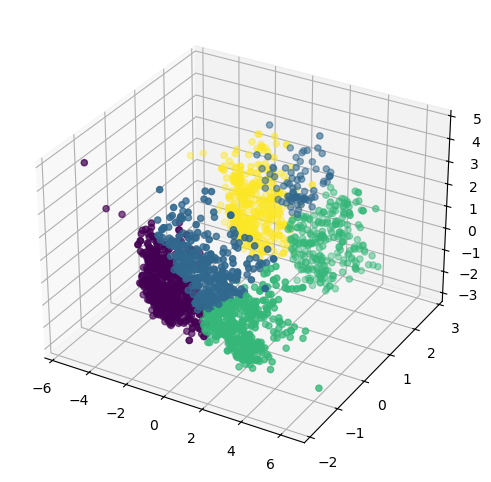

In [46]:
# 3D Plot
fig = plt.figure(
    figsize=(8,6)
)

ax = fig.add_subplot(111,projection="3d")
ax.scatter(
    X_pca[:,0],
    X_pca[:,1],
    X_pca[:,2],
    c=kmeans_labels
)
plt.show()

## 2. Agglomerative Clustering

In [47]:
agg = AgglomerativeClustering(
    n_clusters=4,
    linkage = "ward"
)
agg_labels = agg.fit_predict(X_pca)

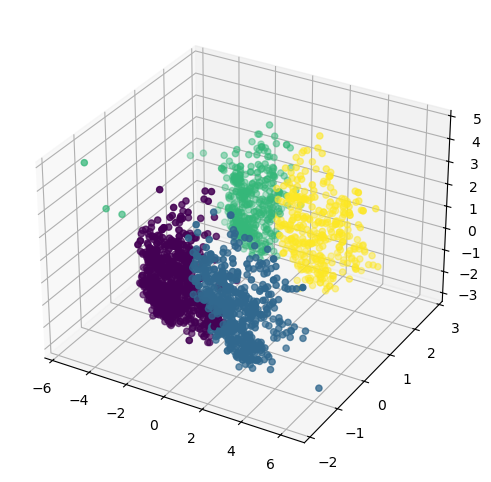

In [48]:
# 3D Plot
fig = plt.figure(
    figsize=(8,6)
)

ax = fig.add_subplot(111,projection="3d")
ax.scatter(
    X_pca[:,0],
    X_pca[:,1],
    X_pca[:,2],
    c=agg_labels
)

## Characterization of Clusters

In [49]:
X["Clusters"] = agg_labels

In [50]:
X.shape

(2236, 19)

In [51]:
X.head()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,CustomerTenureDays,TotalSpending,TotalChildren,Education_Graduate,Education_Postgraduate,Education_Undergraduate,LivingWith_Alone,LivingWith_Partner,Clusters
0,58138.0,58,3,8,10,4,7,0,1,69,663,1617,0,1.0,0.0,0.0,1.0,0.0,3
1,46344.0,38,2,1,1,2,5,0,0,72,113,27,2,1.0,0.0,0.0,1.0,0.0,2
2,71613.0,26,1,8,2,10,4,0,0,61,312,776,0,1.0,0.0,0.0,0.0,1.0,1
3,26646.0,26,2,2,0,4,6,0,0,42,139,53,1,1.0,0.0,0.0,0.0,1.0,0
4,58293.0,94,5,5,3,6,5,0,0,45,161,422,1,0.0,1.0,0.0,0.0,1.0,0


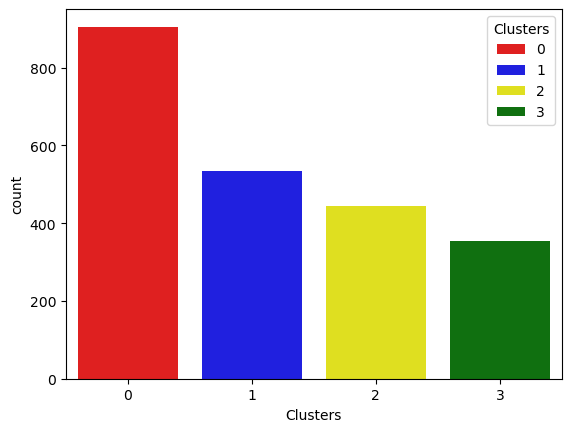

In [52]:
# Number of customers in each cluster 
pal = ["red","blue","yellow","green"]
sns.countplot(
    x = X["Clusters"],
    palette=pal,
    hue=X["Clusters"]
)
plt.show()

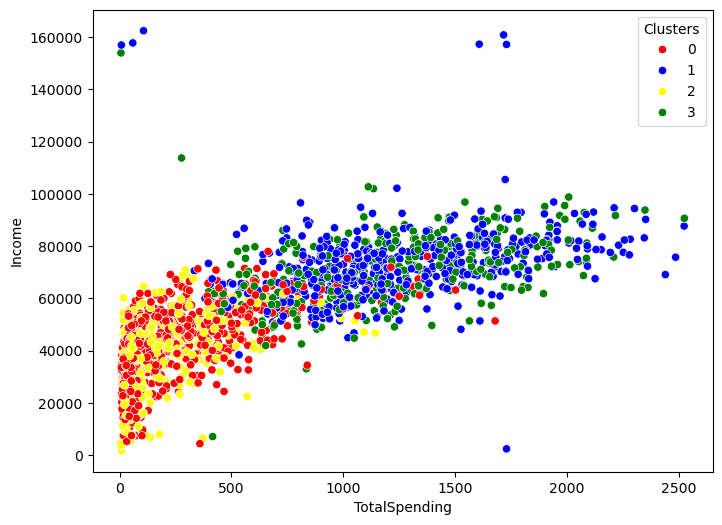

In [53]:
# Income and Spending patterns
plt.figure(figsize=(8,6))
sns.scatterplot(
    x = X["TotalSpending"],
    y = X["Income"],
    hue = X["Clusters"],
    palette = pal
)
plt.show()

In [54]:
# Cluster Summary
cluster_summary = X.groupby("Clusters").mean()
print(cluster_summary)

                Income    Recency  NumDealsPurchases  NumWebPurchases  \
Clusters                                                                
0         39680.580110  48.914917           2.594475         3.153591   
1         72808.445693  49.202247           1.958801         5.687266   
2         36960.143018  48.319820           2.594595         2.713964   
3         70722.681303  50.504249           1.855524         5.790368   

          NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  Complain  \
Clusters                                                                        
0                    0.969061           4.143646           6.307182  0.011050   
1                    5.498127           8.659176           3.580524  0.005618   
2                    0.837838           3.623874           6.659910  0.011261   
3                    5.014164           8.430595           3.728045  0.005666   

          Response        Age  CustomerTenureDays  TotalSpending  \
Cluste

## Insights about 4 different clusters of customers

| Cluster 0 | Cluster 1 | Cluster 2 | Cluster 3 |
|---|---|---|---|
|1. Low income|1. High income|1. Low income|1.High income|
|2. Low spending|2. High spending|2. Low spending|2. High spending|
|3. More children|3. Few Children|3. More children|3. Few children|
|4. Poor response|4. Average response|4. Avg response|4. Best response|
|5. Mid aged|5. Slightly higher age|5. Mid aged|5. Slightly higher age|
|6. With partners|6. With partners|6. Without partners|6. Without partners|
|7. High web visit|7. Low web visit|7. High web visit|7. Low web visit|
|8. Web,Catalog,Store purchase Low|8. Web,Catalog,Store purchase High|8. Web,Catalog,Store purchase Lowest|8. Web,Catalog,Store purchase high|


## Suggestion for different clusters

**Cluster 0** 
- 
1. These are our *Family Shoppers*.
2. We can offer **discounts & coupons** to increase their engagement with Smartcart.

**Cluster 1** 
- 
1. These are our *Premium Customers*.
2. We can offer **loyalty programs** to increase their engagement with Smartcart.

**Cluster 2** 
- 
1. These are our *Digital Browsers*.
2. We can offer **Sales(Heavy discounts & Heavy coupons)** to increase their engagement with Smartcart.

**Cluster 3** 
- 
1. These are our *Best Customer Cluster* to target.
2. They offer best **ROI**.
3. They offer best **Response**.
4. We can offer **Premium Services & Personalized Services** to further increase their engagement with Smartcart.

